# Orthogonalizing Alpha Model Views - OLS Regression Factor Study

Here, we replicate multiple signal formation techniques deployed by the largest firms in quantitative trading.

This is done with synthetic data to emphasize the process behind forming quantitative portfolios from raw signals.

We apply signal formation to industry/dollar/beta neutral portfolios in a sequential, cell-by-cell manner.

We then aggregate this functionality across several functions to modularize this process for a quantitiatve trading infrastructure.

In [1]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [2]:
# Generate sample data
np.random.seed(1)
num_stocks = 50
num_industries = 5

data = {
    'Stock': [f'Stock_{i}' for i in range(num_stocks)],
    'Z_Score': np.random.randn(num_stocks),
    'Industry': np.random.randint(0, num_industries, num_stocks),
    'ExAnte_Beta': np.random.uniform(0.5, 1.5, num_stocks)
}

df = pd.DataFrame(data)

In [3]:
# Create industry dummy variables to form industry/beta relationships
industry_dummies = pd.get_dummies(df['Industry'], prefix='Industry')
industry_dummies.head()

,Industry_0,Industry_1,Industry_2,Industry_3,Industry_4
0,1,0,0,0,0
1,0,0,0,1,0
2,0,0,0,0,1
3,0,0,0,1,0
4,0,0,0,0,1


In [4]:
# Create interaction terms: ExAnte_Beta * Industry_Dummies
interaction_terms = pd.DataFrame(index=industry_dummies.index, columns=industry_dummies.columns)
for i, beta in df['ExAnte_Beta'].items():
    interaction_terms.loc[i] = industry_dummies.iloc[i] * beta

interaction_terms.head()

,Industry_0,Industry_1,Industry_2,Industry_3,Industry_4
0,1.190897,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.497323,0.0
2,0.0,0.0,0.0,0.0,0.672341
3,0.0,0.0,0.0,0.637136,0.0
4,0.0,0.0,0.0,0.0,1.432595


In [5]:
# Regress Z_score views on interaction terms to capture how much our view is explained by industry-specific market factors

# Run OLS regression
X = sm.add_constant(interaction_terms)
y = df['Z_Score']

model = sm.OLS(y,  X.astype(float)).fit()

# Orthogonal alpha model views
residuals = model.resid

residuals.head()

0    1.275207
1    0.163388
2   -0.141346
3   -0.249050
4    0.717135
dtype: float64

Text(0.5, 1.0, 'Orthogonalized Alpha Model Weights')

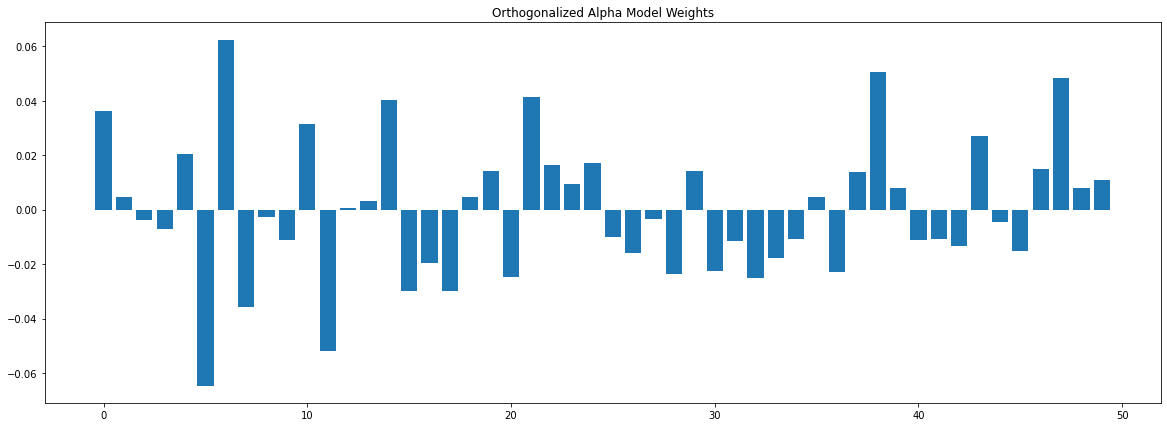

In [6]:
# Get weights from alpha model orthogonalized views
alpha_model_weights = residuals / np.sum(np.abs(residuals))

# Ensure dollar-neutrality
assert -1e-10 < alpha_model_weights.sum() < 1e-10

# Visualize
plt.figure(figsize = (20, 7))
plt.bar(alpha_model_weights.index, alpha_model_weights)
plt.title("Orthogonalized Alpha Model Weights")

# Modularizing Alpha Orthogonalization

This sections creates a series of functions to convert signal views to tradable portfolio weights. These weights can then be scaled to target a given volatilty.

In [169]:
# -------------------------------------------- Utility Functions -------------------------------------------- 

def rank(signal: pd.Series):

    # If pd.Series, maintain indices/names
    if type(signal) == pd.Series:
        ranked_signal = signal.rank()        
    else:
        ranked_signal = np.argsort(signal)

    return ranked_signal

def quantiles(signal: pd.Series, q = .1):

    lower_quantile = np.quantile(signal, q=q)
    upper_quantile = np.quantile(signal, q=1-q)
    
    quantile_signal = signal.where((signal < lower_quantile) | (signal > upper_quantile)).dropna()

    return quantile_signal

def z_score(signal: pd.Series):
    """
    Calculates the Z-score of a signal.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate Z-scores for.
        
    Returns:
        pd.Series: Z-scores of the input signal.
    """
    
    z_score = (signal - np.mean(signal)) / np.std(signal)

    return z_score

def ranked_signal_z_score(signal: pd.Series):
    """
    Calculates Z-scores for a ranked signal and ensures dollar-neutrality.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate Z-scores for.
        
    Returns:
        pd.Series: Z-scores of the ranked signal.
        
    Raises:
        AssertionError: If the sum of Z-scores is not close to zero (dollar-neutrality check).
    """

    # Rank signals
    ranked_signal = rank(signal)

    # Standardize ranked signals
    z_score_signal = z_score(ranked_signal)

    # Check for dollar-neutrality
    assert -1e-10 < z_score_signal.sum() < 1e-10

    # Dollar-neutral alpha model views
    return z_score_signal

def intra_industry_rank(signal: pd.Series, industry: pd.Series):
    
    # Create intra-industry ranked signals
    ranked_signal = signal.groupby(industry).rank()

    return ranked_signal

def intra_industry_mean(signal: pd.Series, industry: pd.Series):

    # Calculate intra-industry mean 
    mean = signal.groupby(industry).transform('mean')

    return mean

def intra_industry_std(signal: pd.Series, industry: pd.Series):
    
    # Calculate intra-industry standard deviation
    sigma = signal.groupby(industry).transform('std')

    return sigma

def intra_industry_quantiles(signal: pd.Series, industry: pd.Series, q=0.1):

    # Group data by industry
    industry_grouped_signal = signal.groupby(industry)
    
    # Calculate quartile values for each industry
    lower_quantiles = industry_grouped_signal.transform(lambda x: np.quantile(x, q))
    upper_quantiles = industry_grouped_signal.transform(lambda x: np.quantile(x, (1 - q)))
    
    # Isolate values in the bottom and top quartiles within each industry
    quantile_signal = signal.where((signal <= lower_quantiles) | (signal >= upper_quantiles)).dropna()

    return quantile_signal

def intra_industry_z_score(signal: pd.Series, industry: pd.Series):
    """
    Calculates industry-neutral Z-scores for a raw signal and ensures dollar-neutrality.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate Z-scores for.
        industry (pd.Series): Series indicating the industry of each stock.
        
    Returns:
        pd.Series: Industry-neutral Z-scores of the signal.
        
    Raises:
        AssertionError: If the sum of Z-scores within each industry is not close to zero (dollar-neutrality check).
    """

    # Calculate intra-industry ranked signal mean and standard deviation
    industry_mean = intra_industry_mean(signal=signal, industry=industry)
    industry_sigma = intra_industry_std(signal=signal, industry=industry)

    # Standardize intra-industry ranked signals
    z_score = (signal - industry_mean) / industry_sigma

    # Check for dollar-neutrality
    assert -1e-10 < z_score.groupby(industry).sum().sum() < 1e-10

    # Industry dollar-neutral alpha model views
    return z_score 

def intra_industry_ranked_signal_z_score(signal: pd.Series, industry: pd.Series):
    """
    Calculates industry-neutral Z-scores for a ranked signal and ensures dollar-neutrality.
    
    Parameters:
        signal (pd.Series): Series of the signal to calculate Z-scores for.
        industry (pd.Series): Series indicating the industry of each stock.
        
    Returns:
        pd.Series: Industry-neutral Z-scores of the ranked signal.
        
    Raises:
        AssertionError: If the sum of Z-scores within each industry is not close to zero (dollar-neutrality check).
    """

    # Create intra-industry ranked signals
    ranked_signal = intra_industry_rank(signal=signal, industry=industry) 

    # Get the intra-industry z-score of ranked signals
    z_score = intra_industry_z_score(signal=ranked_signal, industry=industry)

    # Check for dollar-neutrality
    assert -1e-10 < z_score.groupby(industry).sum().sum() < 1e-10

    # Industry dollar-neutral alpha model views
    return z_score


def beta_neutralize(views: pd.Series, betas: pd.Series) -> pd.Series:
    """
    Orthogonalizes alpha model to the market factor. Transforms alpha 
    model views to beta-neutralized weights based on stock-level betas.   
    These alpha weights can then be scaled to target desired level of vol.

    This function will eventually be extended to orthogonalize alpha model 
    to other market factors (e.g., Fama-French factors).
    
    Parameters:
        views (pd.Series): Series of your alpha model views.
        betas (pd.Series): Series of ex-ante stock-level betas.
        
    Returns:
        pd.Series: Alpha weights for beta-neutralized views.
    """

    # Preprocess data
    X = sm.add_constant(betas).astype(float)
    y = views.astype(float)

    # Regress model views on stock-level betas
    model = sm.OLS(endog=y, exog=X).fit() 

    # Orthogonalize views to create your alpha weights
    alpha_views = model.resid
    w = alpha_views / np.sum(np.abs(alpha_views))

    # Ensure dollar neturality
    assert  -1e-10 < np.sum(w) < 1e-10

    return w

def industry_beta_neutralize(views: pd.Series, industry: pd.Series, betas: pd.Series):
    """
    Creates industry beta-neutral alpha weights for views based on stock-level betas and industries.
    Views are expected to be industry dollar-neutral before passed to this function... if views are not
    dollar neutral beforehand, there is no guaruntee that weights will be industry-dollar neutral.
    
    Parameters:
        views (pd.Series): Series of your alpha model views.
        industry (pd.Series): Series indicating the industry of each stock.
        betas (pd.Series): Series of ex-ante stock-level betas.
        
    Returns:
        pd.Series: Alpha weights for industry beta-neutralized views.
    """

    # Create industry dummy variables
    industry_dummies = pd.get_dummies(industry, prefix='Industry')

    print(industry_dummies.shape, betas.shape)
    
    # Create interaction terms: ExAnte_Beta * Industry_Dummies
    interaction_terms = pd.DataFrame(index=industry_dummies.index, columns=industry_dummies.columns)
    for i, beta in betas.items():
        interaction_terms.loc[i] = industry_dummies.loc[i] * beta

    # Beta Neutralize beta within industry
    w = beta_neutralize(views=views, betas=interaction_terms)

    return w

def plot_weights(w: pd.Series, title=None):

    plt.figure(figsize=(20, 5))
    plt.bar(w.index, w)
    if title:
        plt.title(title)
    plt.show()

Run the previous simulation on a raw signal while leveragin new modularized infrastructure

In [157]:
# Generate sample data
np.random.seed(1)
num_stocks = 50
num_industries = 5

# Generate synthetic data including the raw signal instead of the Z-Scored signal
data = {
    'Stock': [f'Stock_{i}' for i in range(num_stocks)],
    'Signal': np.random.randn(num_stocks),
    'Industry': np.random.randint(0, num_industries, num_stocks),
    'ExAnte_Beta': np.random.uniform(0.5, 1.5, num_stocks)
}

df = pd.DataFrame(data)

(50, 5) (50,)


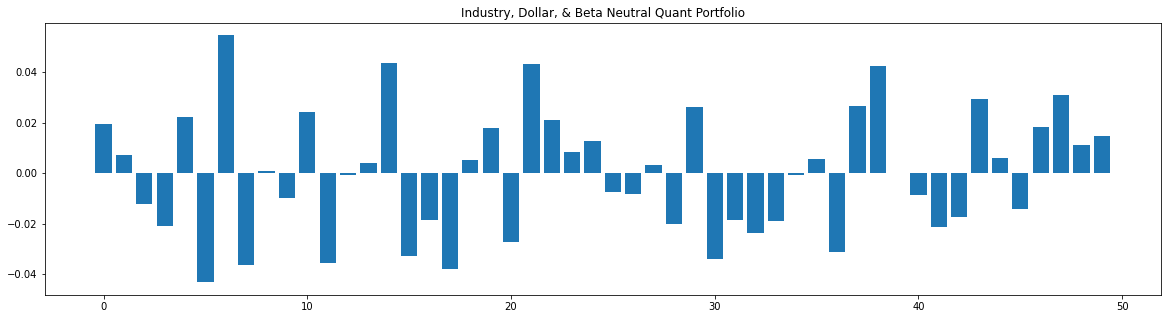

0    0.019340
1    0.007194
2   -0.012172
3   -0.020727
4    0.022303
dtype: float64

In [168]:
# Industry & Dollar Neutralize Standardized Ranked Alpha Signal
df['Z_score'] = intra_industry_ranked_signal_z_score(signal=df['Signal'], industry=data['Industry'])

# Convert Z-Scored signal into beta dollar-neutral portfolio weights
w = industry_beta_neutralize(views=df['Z_score'], industry=df['Industry'], betas=df['ExAnte_Beta'])
plot_weights(w, title="Industry, Dollar, & Beta Neutral Quant Portfolio")
w.head()

Different Signal Transformation Alpha Model - Non Industry Neutral

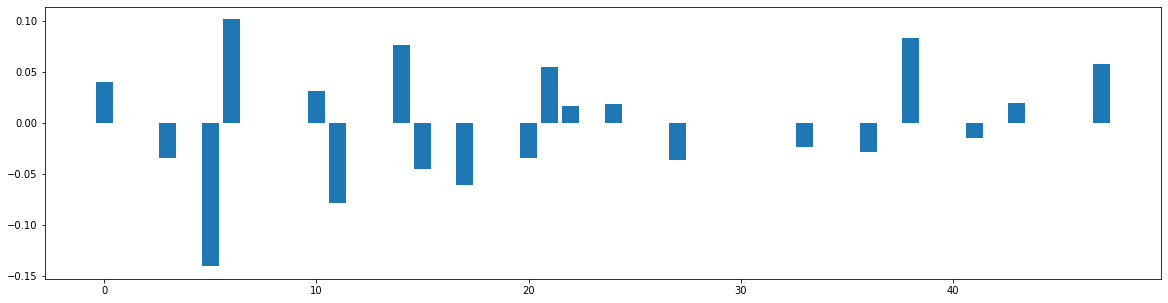

In [160]:
new_views = z_score(quantiles(df.Signal, q=0.2))
w = beta_neutralize(new_views, betas=df['ExAnte_Beta'].loc[new_views.index])
plot_weights(w)

Different Signal Transformation Alpha Model - Non Industry Neutral

(28, 5) (28,)


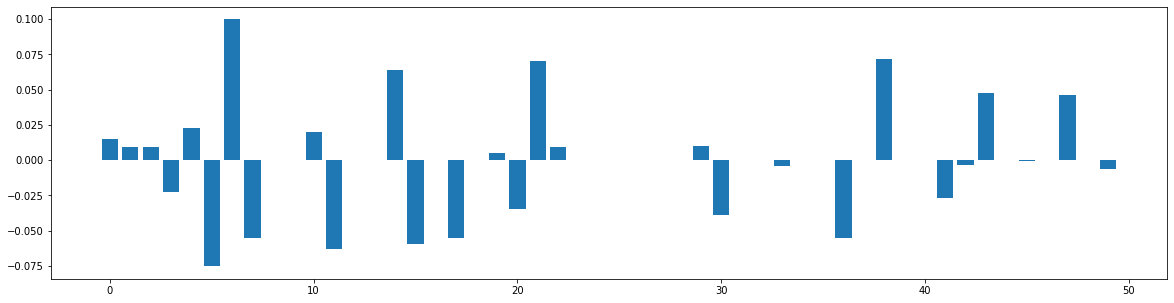

In [172]:
# Get the top and bottm intra-industry quantiles of signal
quantile_signal = intra_industry_quantiles(signal=df.Signal, industry=df.Industry, q=0.25)

# Redifine tradable universe
quantile_df = df.loc[quantile_signal.index]

# Intra-industry rank the quantiles, then z-score the rank of the quantiles
z_score_ranked_quantile_signal = intra_industry_ranked_signal_z_score(signal=quantile_signal, industry=quantile_df.Industry)

# Beta, industry, and dollar-neutralize the remanining portfolio
w = industry_beta_neutralize(views=z_score_ranked_quantile_signal, industry=quantile_df['Industry'], betas=quantile_df['ExAnte_Beta'])

plot_weights(w)